# U-Net v1.0

Arquitectura basada en:
https://commons.wikimedia.org/wiki/File:Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png

![image.png](images/unet_v1.0.png)

## Modules

In [13]:
import os
from pathlib import Path

# Import zipfile for zip file handling
import zipfile

# Import pytorch to build Models 
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# import numpy for math calculations
import numpy as np

# Import skimage for image processing
from skimage.color import lab2rgb

from torchsummary import summary

# -------------Must Import-----------------
from dataset import ImageColorizationDataset
from training import train_model


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device {device}")

Using device cpu


## .ZIP Extraction

Download the .zip file first: 
https://www.kaggle.com/datasets/shravankumar9892/image-colorization

In [3]:
extracted_folder = 'data'
if not os.path.exists(extracted_folder):
    with zipfile.ZipFile("archive.zip","r") as zip_ref:
        zip_ref.extractall(extracted_folder)

# List all the files in the extracted folder
os.listdir(extracted_folder)

['ab', 'l', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5']

## Data Preparation

In [4]:
ab_path = Path("data/ab/ab")
l_path = Path("data/l")

### Data Loader

In [5]:
batch_size = 32
# Prepare the Datasets
all_dataset = ImageColorizationDataset(l_dir=l_path, ab_dir=ab_path, reduced=True)

# Definir las proporciones para entrenamiento, validación y prueba
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.1

# Calcular las longitudes de cada conjunto
total_count = len(all_dataset)
train_count = int(total_count * train_ratio)
valid_count = int(total_count * valid_ratio)
test_count = total_count - train_count - valid_count  # Asegura que sumen el total

# Establecer la semilla para reproducibilidad
torch.manual_seed(42)

# Dividir el dataset
train_dataset, valid_dataset, test_dataset = random_split(all_dataset, [train_count, valid_count, test_count])

# Crear DataLoader para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
# Imprimir las longitudes de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de validación:", len(valid_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))


Tamaño del conjunto de entrenamiento: 2250
Tamaño del conjunto de validación: 450
Tamaño del conjunto de prueba: 300


### Data Visualization

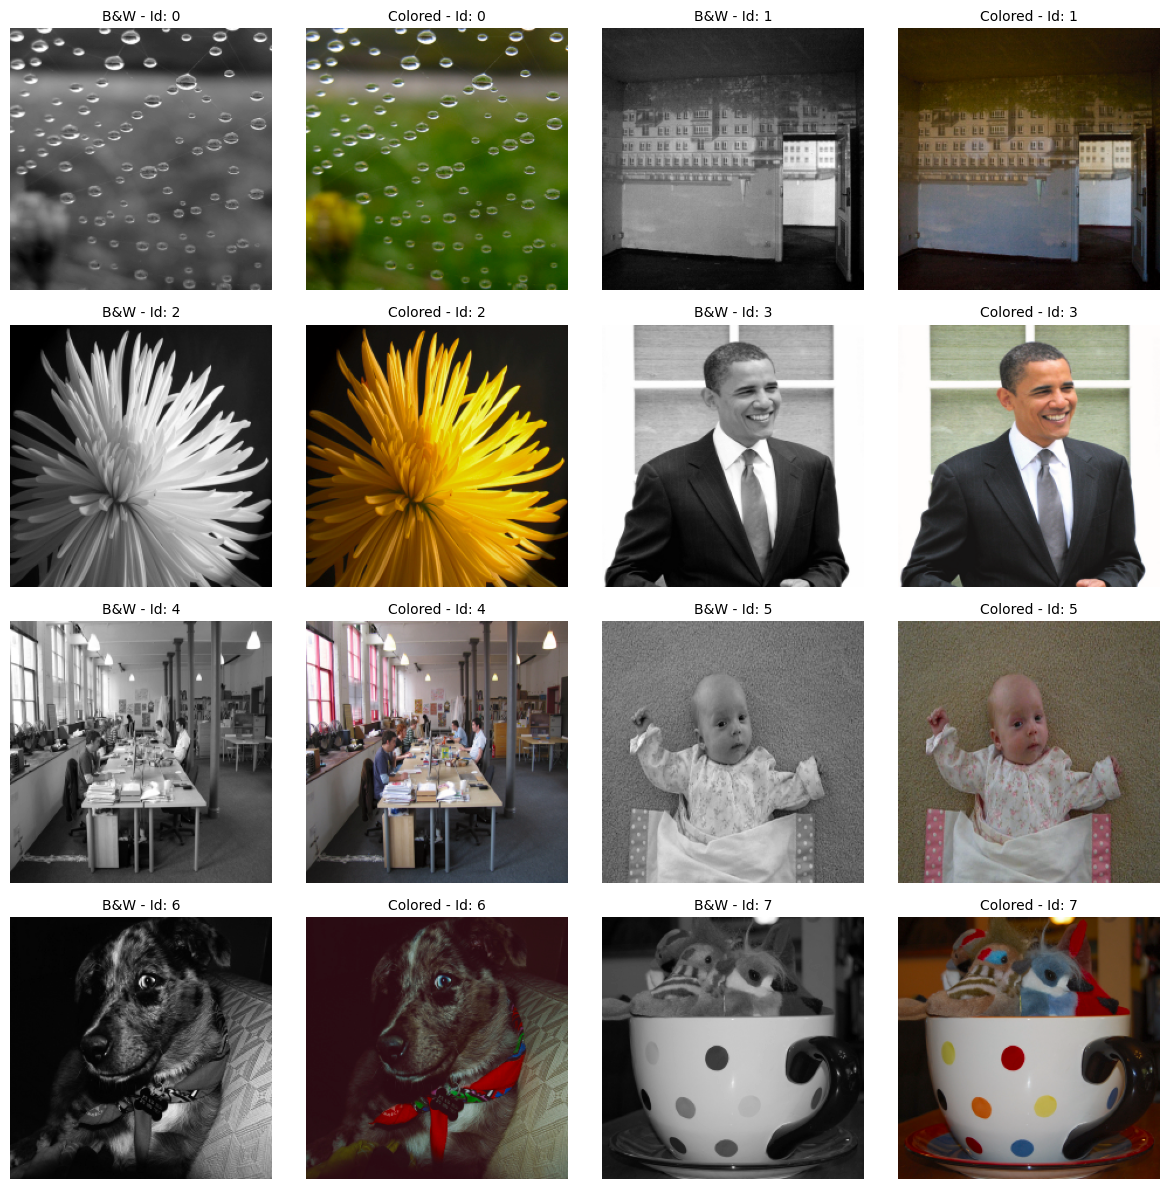

In [11]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

dataiter = iter(train_loader)
images, labels = next(dataiter)  # Carga un batch del DataLoader

# Configuración del plot
fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # 4 filas, 4 columnas para 8 pares de imágenes

for i in range(8):  # Solo necesitamos 8 pares de imágenes, total 16 subplots
    row = i // 2  # Cada fila tiene 2 pares
    col = (i % 2) * 2  # Columna alterna para B&W y Colored (0, 2 para B&W; 1, 3 para Colored)

    l_image = tensor_to_numpy(images[i]).squeeze()  # [H, W], quita el canal si es 1
    ab_image = tensor_to_numpy(labels[i])  # [2, H, W]

    # Asegurarse de que los datos están en la escala correcta
    l_image = l_image * 100  # Escalar L de [0, 1] a [0, 100]
    ab_image = (ab_image - 0.5) * 255  # Escalar a y b de [-0.5, 0.5] a [-128, 127]

    # Imagen en escala de grises
    axs[row, col].imshow(l_image, cmap='gray')
    axs[row, col].set_title(f'B&W - Id: {i}', fontsize=10)
    axs[row, col].axis('off')  # Desactiva los ejes

    # Imagen coloreada
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = l_image  # L canal
    img_lab[:,:,1:] = ab_image.transpose(1, 2, 0)  # a y b canales
    img_rgb = lab2rgb(img_lab)  # Convierte LAB a RGB
    axs[row, col + 1].imshow(img_rgb)
    axs[row, col + 1].set_title(f'Colored - Id: {i}', fontsize=10)
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

## Architecture: U-Net v1.0

In [8]:

class UNet_1(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.e1 = nn.Conv2d(1, 32, kernel_size=4, padding=1, stride=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.e2 = nn.Conv2d(32, 64, kernel_size=4, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.e3 = nn.Conv2d(64, 128, kernel_size=4, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(128)

        # Decoder
        self.d1 = nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(64)
        self.d2 = nn.ConvTranspose2d(128, 32, kernel_size=4, padding=1, stride=2)
        self.bn5 = nn.BatchNorm2d(32)
        self.d3 = nn.ConvTranspose2d(64, 2, kernel_size=4, padding=1, stride=2)

        # Output layer
        self.outconv = nn.Conv2d(3, 2, kernel_size=3, padding=1, stride=1)

    def forward(self, x):
        # Encoder
        xe1 = F.relu(self.bn1(self.e1(x)))
        xe2 = F.relu(self.bn2(self.e2(xe1)))
        xe3 = F.relu(self.bn3(self.e3(xe2)))

        # Decoder
        xd1 = F.relu(self.bn4(self.d1(xe3)))
        xd1_cat = torch.cat([xd1, xe2], dim=1)
        
        xd2 = F.relu(self.bn5(self.d2(xd1_cat)))
        xd2_cat = torch.cat([xd2, xe1], dim=1)
        
        xd3 = self.d3(xd2_cat)

        # Concatenate the final output with the original input (assumed to be 1 channel)
        out = self.outconv(torch.cat([xd3, x], dim=1))

        return out
        

In [17]:
architecture = UNet_1()
summary(architecture, (1, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             544
       BatchNorm2d-2         [32, 32, 112, 112]              64
            Conv2d-3           [32, 64, 56, 56]          32,832
       BatchNorm2d-4           [32, 64, 56, 56]             128
            Conv2d-5          [32, 128, 28, 28]         131,200
       BatchNorm2d-6          [32, 128, 28, 28]             256
   ConvTranspose2d-7           [32, 64, 56, 56]         131,136
       BatchNorm2d-8           [32, 64, 56, 56]             128
   ConvTranspose2d-9         [32, 32, 112, 112]          65,568
      BatchNorm2d-10         [32, 32, 112, 112]              64
  ConvTranspose2d-11          [32, 2, 224, 224]           2,050
           Conv2d-12          [32, 2, 224, 224]              56
Total params: 364,026
Trainable params: 364,026
Non-trainable params: 0
-------------------------------

In [9]:
architecture = UNet_1()
file_name = "unet_1.0"
train_model(train_loader, architecture, file_name, epochs=10, learning_rate=0.001, device=device)

Number of parameters: 364026
Epoch 1


Epoch 1:   1%|▏         | 1/71 [00:03<04:07,  3.54s/it, loss=0.7178]


KeyboardInterrupt: 